# Codon Usage Bias: Discarded Analysis

### Kathleen Hablutzel
### BIO 334/335 Bioinformatics Final Project

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import math
import itertools
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.utils import shuffle
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# all my helper functions
from helper import *

In [4]:
# load data
bias_pd = pd.read_csv("datasets/report/discarded_data.csv")
bias_pd.shape

(816, 68)

In [5]:
bias_pd.head()

,UUU,UUC,UUA,UUG,CUU,CUC,CUA,CUG,AUU,AUC,...,AGA,AGG,GGU,GGC,GGA,GGG,AccessionNum,SeqLen,Species,Taxon
0,0.500000,0.500000,0.000000,0.111111,0.111111,0.555556,0.000000,0.222222,0.333333,0.333333,...,0.20,0.2,0.125,0.125000,0.375000,0.375,GCF_003709585.1_Aci_jub_2,121033293,Acinonyx_jubatus,vertebrate_mammalian
1,0.500000,0.500000,0.000000,0.000000,0.117647,0.352941,0.058824,0.470588,0.285714,0.571429,...,0.00,0.0,0.000,0.200000,0.000000,0.800,GCF_002007445.1_ASM200744v2,106483281,Ailuropoda_melanoleuca,vertebrate_mammalian
2,0.666667,0.333333,0.285714,0.142857,0.142857,0.142857,0.000000,0.285714,0.500000,0.500000,...,0.20,0.2,0.125,0.250000,0.375000,0.250,GCF_000952055.2_Anan_2.0,90718989,Aotus_nancymaae,vertebrate_mammalian
3,1.000000,0.000000,0.111111,0.222222,0.000000,0.444444,0.111111,0.111111,0.400000,0.400000,...,0.30,0.3,0.500,0.000000,0.500000,0.000,GCF_014825515.1_WHU_Ajam_v2,76787673,Artibeus_jamaicensis,vertebrate_mammalian
4,0.666667,0.333333,0.125000,0.062500,0.375000,0.125000,0.000000,0.312500,0.666667,0.000000,...,0.25,0.5,0.000,0.166667,0.333333,0.500,GCF_011762505.1_mArvNil1.pat.X,75364476,Arvicanthis_niloticus,vertebrate_mammalian


### Results

In [6]:
# summarize entire dataset in 2d
drop_columns=["AccessionNum", "SeqLen", "Species", "Taxon", "UAA", "UAG", "UGA", "AUG"]
bias_2d = reduce_dim(bias_pd, dim=2, vertebrate=False, drop_columns=drop_columns)

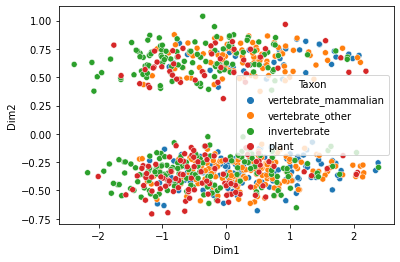

In [7]:
# plot of all CUB in the dataset - overwhelmed by the number of viruses vs. other organisms
sns.scatterplot(data=bias_2d, x='Dim1', y='Dim2', hue='Taxon');

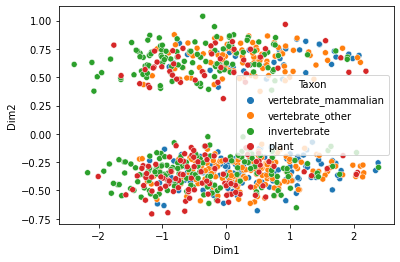

In [8]:
# plot with fewer viruses - still hard to see any meaningful differences
sns.scatterplot(data=bias_2d.head(1200), x='Dim1', y='Dim2', hue='Taxon');

### Clustering Animals - CUB differences among taxa?
We see more of a clustering by CUB if we just look at animals.

In [9]:
# get dataset of just animals
is_animal = (bias_pd["Taxon"] == "vertebrate_mammalian") | (bias_pd["Taxon"] == "vertebrate_other") | \
            (bias_pd["Taxon"] == "invertebrate")
a_bias = bias_pd[is_animal].copy()
# label as vertebrate or invertebrate
# https://datatofish.com/if-condition-in-pandas-dataframe/
a_bias["Vertebrate"] = a_bias["Taxon"].apply(lambda x: 0 if (x == "invertebrate") else 1)
a_bias.shape

(675, 69)

In [10]:
a_bias[['AUG', 'GGC', 'GGA', 'GGG', 'Vertebrate']]

,AUG,GGC,GGA,GGG,Vertebrate
0,1,0.125000,0.375000,0.375000,1
1,1,0.200000,0.000000,0.800000,1
2,1,0.250000,0.375000,0.250000,1
3,1,0.000000,0.500000,0.000000,1
4,1,0.166667,0.333333,0.500000,1
...,...,...,...,...,...
670,1,1.000000,0.000000,0.000000,0
671,1,0.166667,0.333333,0.500000,0
672,1,0.333333,0.666667,0.000000,0
673,1,0.125000,0.375000,0.000000,0


In [11]:
a_bias.head()

,UUU,UUC,UUA,UUG,CUU,CUC,CUA,CUG,AUU,AUC,...,AGG,GGU,GGC,GGA,GGG,AccessionNum,SeqLen,Species,Taxon,Vertebrate
0,0.500000,0.500000,0.000000,0.111111,0.111111,0.555556,0.000000,0.222222,0.333333,0.333333,...,0.2,0.125,0.125000,0.375000,0.375,GCF_003709585.1_Aci_jub_2,121033293,Acinonyx_jubatus,vertebrate_mammalian,1
1,0.500000,0.500000,0.000000,0.000000,0.117647,0.352941,0.058824,0.470588,0.285714,0.571429,...,0.0,0.000,0.200000,0.000000,0.800,GCF_002007445.1_ASM200744v2,106483281,Ailuropoda_melanoleuca,vertebrate_mammalian,1
2,0.666667,0.333333,0.285714,0.142857,0.142857,0.142857,0.000000,0.285714,0.500000,0.500000,...,0.2,0.125,0.250000,0.375000,0.250,GCF_000952055.2_Anan_2.0,90718989,Aotus_nancymaae,vertebrate_mammalian,1
3,1.000000,0.000000,0.111111,0.222222,0.000000,0.444444,0.111111,0.111111,0.400000,0.400000,...,0.3,0.500,0.000000,0.500000,0.000,GCF_014825515.1_WHU_Ajam_v2,76787673,Artibeus_jamaicensis,vertebrate_mammalian,1
4,0.666667,0.333333,0.125000,0.062500,0.375000,0.125000,0.000000,0.312500,0.666667,0.000000,...,0.5,0.000,0.166667,0.333333,0.500,GCF_011762505.1_mArvNil1.pat.X,75364476,Arvicanthis_niloticus,vertebrate_mammalian,1


In [12]:
# summarize in 2d
a_bias_2d = reduce_dim(a_bias, dim=2, drop_columns=drop_columns, vertebrate=True)
a_bias_2d.head()

,Dim1,Dim2,AccessionNum,SeqLen,Species,Taxon,UAA,UAG,UGA,AUG,Vertebrate
0,-0.109295,-0.663427,GCF_003709585.1_Aci_jub_2,121033293,Acinonyx_jubatus,vertebrate_mammalian,0,0,0,1,1
1,-0.413537,-0.363831,GCF_002007445.1_ASM200744v2,106483281,Ailuropoda_melanoleuca,vertebrate_mammalian,0,0,0,1,1
2,-0.135093,-0.381061,GCF_000952055.2_Anan_2.0,90718989,Aotus_nancymaae,vertebrate_mammalian,0,0,0,1,1
3,0.668326,-0.281602,GCF_014825515.1_WHU_Ajam_v2,76787673,Artibeus_jamaicensis,vertebrate_mammalian,0,0,0,1,1
4,1.094101,-0.456476,GCF_011762505.1_mArvNil1.pat.X,75364476,Arvicanthis_niloticus,vertebrate_mammalian,0,0,0,1,1


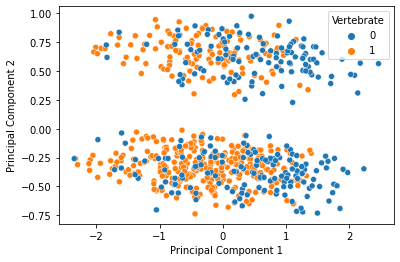

In [13]:
# cub for vertebrate vs. invertebrate
sns.scatterplot(data=a_bias_2d, x='Dim1', y='Dim2', hue='Vertebrate')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2');

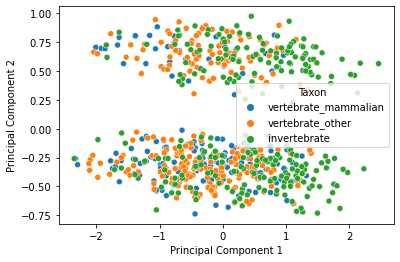

In [14]:
# cub by taxa
sns.scatterplot(data=a_bias_2d, x='Dim1', y='Dim2', hue='Taxon')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2');

It's strange that animals fall into two distinct clusters. I wonder what the distinction is—clearly it's not across our observed taxonomic boundaries. Let's try applying a clustering algorithm to animals based on codon bias, and we'll take a look at the resulting clusters.

### clustering animals by CUB

In [15]:
# create dataset with just CUB data
a_bias_num = a_bias.drop(columns=["AccessionNum", "SeqLen", "Species", "Taxon", "UAA", "UAG", "UGA", "AUG", "Vertebrate"])

In [16]:
a_bias_num.head()

,UUU,UUC,UUA,UUG,CUU,CUC,CUA,CUG,AUU,AUC,...,CGU,CGC,CGA,CGG,AGA,AGG,GGU,GGC,GGA,GGG
0,0.500000,0.500000,0.000000,0.111111,0.111111,0.555556,0.000000,0.222222,0.333333,0.333333,...,0.2,0.0,0.00,0.4,0.20,0.2,0.125,0.125000,0.375000,0.375
1,0.500000,0.500000,0.000000,0.000000,0.117647,0.352941,0.058824,0.470588,0.285714,0.571429,...,0.0,0.0,0.00,0.0,0.00,0.0,0.000,0.200000,0.000000,0.800
2,0.666667,0.333333,0.285714,0.142857,0.142857,0.142857,0.000000,0.285714,0.500000,0.500000,...,0.2,0.4,0.00,0.0,0.20,0.2,0.125,0.250000,0.375000,0.250
3,1.000000,0.000000,0.111111,0.222222,0.000000,0.444444,0.111111,0.111111,0.400000,0.400000,...,0.1,0.1,0.00,0.2,0.30,0.3,0.500,0.000000,0.500000,0.000
4,0.666667,0.333333,0.125000,0.062500,0.375000,0.125000,0.000000,0.312500,0.666667,0.000000,...,0.0,0.0,0.25,0.0,0.25,0.5,0.000,0.166667,0.333333,0.500


In [17]:
a_bias_norm = a_bias_num.to_numpy()
print(a_bias_norm.shape)

# cluster with k-means
labels, centers = kmeans_sklearn(a_bias_norm, 2)

(675, 60)


In [18]:
# append cluster labels to visualization df
a_bias_2d["Cluster"] = labels
a_bias_2d["Cluster"] = a_bias_2d["Cluster"].apply(lambda x: 0 if x else 1)  # swap label numbers to match vertebrate labels

a_bias_2d.head()

,Dim1,Dim2,AccessionNum,SeqLen,Species,Taxon,UAA,UAG,UGA,AUG,Vertebrate,Cluster
0,-0.109295,-0.663427,GCF_003709585.1_Aci_jub_2,121033293,Acinonyx_jubatus,vertebrate_mammalian,0,0,0,1,1,1
1,-0.413537,-0.363831,GCF_002007445.1_ASM200744v2,106483281,Ailuropoda_melanoleuca,vertebrate_mammalian,0,0,0,1,1,1
2,-0.135093,-0.381061,GCF_000952055.2_Anan_2.0,90718989,Aotus_nancymaae,vertebrate_mammalian,0,0,0,1,1,1
3,0.668326,-0.281602,GCF_014825515.1_WHU_Ajam_v2,76787673,Artibeus_jamaicensis,vertebrate_mammalian,0,0,0,1,1,0
4,1.094101,-0.456476,GCF_011762505.1_mArvNil1.pat.X,75364476,Arvicanthis_niloticus,vertebrate_mammalian,0,0,0,1,1,0


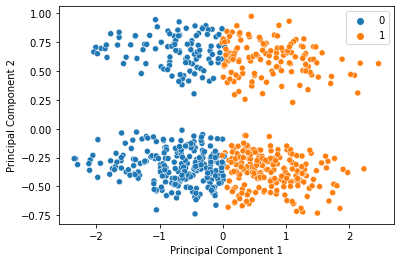

In [19]:
# visualize
sns.scatterplot(data=a_bias_2d, x='Dim1', y='Dim2', hue=labels)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2');

Now we plot newly generated clusters next to known vertebrate/invertebrate identifiers.

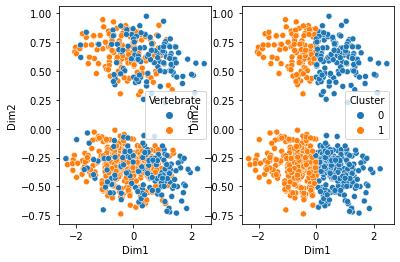

In [20]:
# https://www.tutorialspoint.com/how-do-i-plot-two-countplot-graphs-side-by-side-in-seaborn-using-matplotlib
f, axes = plt.subplots(1, 2)
sns.scatterplot(data=a_bias_2d, x='Dim1', y='Dim2', hue='Vertebrate', ax=axes[0])
sns.scatterplot(data=a_bias_2d, x='Dim1', y='Dim2', hue='Cluster', ax=axes[1]);

In [21]:
# summary table of known classification vs. newly found clusters
a_bias_2d.groupby(['Vertebrate', 'Cluster'])['Species'].count()

Vertebrate  Cluster
0           0          181
            1           76
1           0          151
            1          267
Name: Species, dtype: int64

Our clustering algorithm does not find clear boundaries among our two observed clusters.

## Unpacking the Two Clusters

When we plot the distributions of each codon's usage frequency, we observe that UGG (Tryptophan) is acting as a categorical variable, only taking values of 0 or 1.

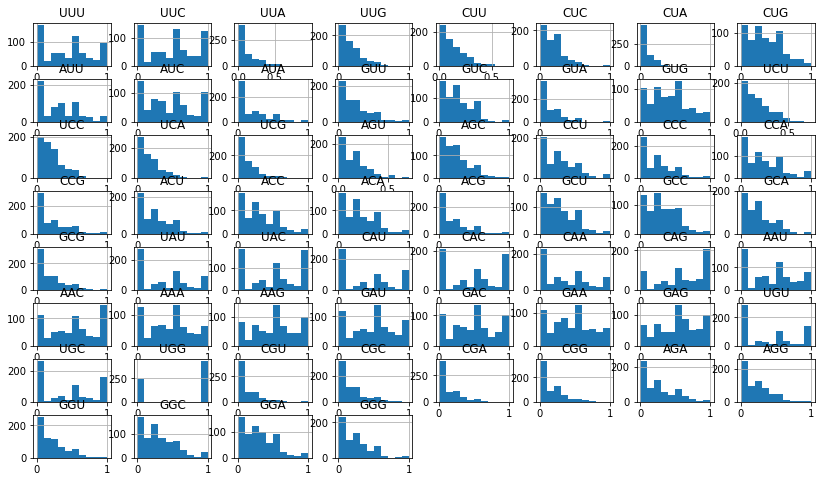

In [22]:
a_bias_num.hist(figsize=(14,8));

In [23]:
pd.set_option('display.max_columns', 64)
a_bias_num.describe()

,UUU,UUC,UUA,UUG,CUU,CUC,CUA,CUG,AUU,AUC,AUA,GUU,GUC,GUA,GUG,UCU,UCC,UCA,UCG,AGU,AGC,CCU,CCC,CCA,CCG,ACU,ACC,ACA,ACG,GCU,GCC,GCA,GCG,UAU,UAC,CAU,CAC,CAA,CAG,AAU,AAC,AAA,AAG,GAU,GAC,GAA,GAG,UGU,UGC,UGG,CGU,CGC,CGA,CGG,AGA,AGG,GGU,GGC,GGA,GGG
count,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000,675.00000,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000
mean,0.437889,0.491000,0.115660,0.165521,0.129478,0.179161,0.072016,0.335201,0.309778,0.432914,0.193605,0.218688,0.247552,0.132447,0.393906,0.166569,0.192078,0.154526,0.116475,0.141822,0.227049,0.262274,0.224791,0.293398,0.203241,0.234352,0.292837,0.281493,0.182429,0.276831,0.301062,0.242201,0.171017,0.364289,0.500896,0.392342,0.486177,0.352444,0.612000,0.429093,0.520536,0.445995,0.51845,0.483047,0.493250,0.441091,0.539649,0.382892,0.427479,0.647407,0.117564,0.157299,0.116275,0.144087,0.240563,0.206435,0.195082,0.282984,0.295712,0.214370
std,0.343272,0.348738,0.155518,0.162522,0.127776,0.158285,0.102978,0.238071,0.284508,0.335973,0.241167,0.221457,0.204513,0.178431,0.268719,0.150498,0.168437,0.161612,0.150053,0.138164,0.192854,0.241480,0.231669,0.263926,0.235130,0.222976,0.251784,0.239982,0.220898,0.224822,0.223895,0.216570,0.202173,0.361441,0.386113,0.381363,0.396047,0.334733,0.348265,0.338021,0.344777,0.306155,0.31034,0.319860,0.320239,0.295987,0.299181,0.393153,0.403778,0.478132,0.178797,0.189711,0.157404,0.176299,0.239102,0.205605,0.196614,0.243809,0.240957,0.205379
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.153846,0.000000,0.154762,0.000000,0.000000,0.090909,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.111111,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.250000,0.200000,0.30000,0.250000,0.250000,0.222222,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.095455,0.111111,0.000000
50%,0.500000,0.500000,0.066667,0.133333,0.111111,0.166667,0.000000,0.333333,0.333333,0.400000,0.125000,0.166667,0.230769,0.000000,0.400000,0.142857,0.166667,0.125000,0.083333,0.125000,0.200000,0.250000,0.200000,0.250000,0.150000,0.200000,0.250000,0.250000,0.142857,0.250000,0.285714,0.200000,0.117647,0.333333,0.500000,0.333333,0.500000,0.333333,0.666667,0.444444,0.500000,0.473684,0.50000,0.500000,0.500000,0.428571,0.555556,0.333333,0.500000,1.000000,0.000000,0.111111,0.000000,0.100000,0.200000,0.166667,0.166667,0.250000,0.272727,0.200000
75%,0.666667,0.750000,0.188988,0.250000,0.205263,0.272727,0.114379,0.500000,0.500000,0.666667,0.333333,0.333333,0.375000,0.250000,0.571429,0.250000,0.285714,0.250000,0.184659,0.222222,0.333333,0.400000,0.333333,0.500000,0.333333,0.375000,0.500000,0.428571,0.300000,0.400000,0.444444,0.375000,0.285714,0.666667,1.000000,0.666667,1.000000,0.600000,1.000000,0.666667,0.800000,0.666

If we repeat our dimension reduction excluding the tryptophan codon in addition to the methionine and stop codons, we no longer observe two clusters of data:

In [24]:
# summarize in 2d
a_bias_no_ugg = reduce_dim(a_bias, dim=2, drop_columns=drop_columns + ["UGG"], vertebrate=True)
a_bias_no_ugg.head()

,Dim1,Dim2,AccessionNum,SeqLen,Species,Taxon,UAA,UAG,UGA,AUG,Vertebrate,UGG,Vertebrate
0,-0.094550,-0.840146,GCF_003709585.1_Aci_jub_2,121033293,Acinonyx_jubatus,vertebrate_mammalian,0,0,0,1,1,1,1
1,-0.399652,0.107249,GCF_002007445.1_ASM200744v2,106483281,Ailuropoda_melanoleuca,vertebrate_mammalian,0,0,0,1,1,1,1
2,-0.121369,0.002070,GCF_000952055.2_Anan_2.0,90718989,Aotus_nancymaae,vertebrate_mammalian,0,0,0,1,1,1,1
3,0.681652,0.065053,GCF_014825515.1_WHU_Ajam_v2,76787673,Artibeus_jamaicensis,vertebrate_mammalian,0,0,0,1,1,1,1
4,1.109017,-0.084780,GCF_011762505.1_mArvNil1.pat.X,75364476,Arvicanthis_niloticus,vertebrate_mammalian,0,0,0,1,1,1,1


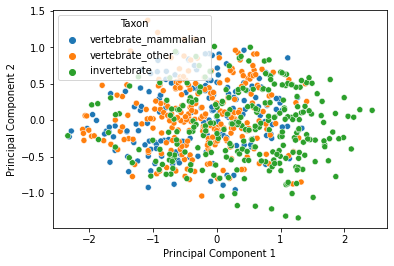

In [25]:
# visualize in 2d
sns.scatterplot(data=a_bias_no_ugg, x='Dim1', y='Dim2', hue='Taxon')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2');

In [28]:
# import the new data
# and calculate how often tryptophan appears in a genome
new_data = pd.read_csv("datasets/report/cub_full_genome.csv")
new_data.head()

,UUU,UUC,UUA,UUG,CUU,CUC,CUA,CUG,AUU,AUC,AUA,AUG,GUU,GUC,GUA,GUG,UCU,UCC,UCA,UCG,AGU,AGC,CCU,CCC,CCA,CCG,ACU,ACC,ACA,ACG,GCU,GCC,...,UAG,UGA,CAU,CAC,CAA,CAG,AAU,AAC,AAA,AAG,GAU,GAC,GAA,GAG,UGU,UGC,UGG,CGU,CGC,CGA,CGG,AGA,AGG,GGU,GGC,GGA,GGG,AccessionNum,SeqLen,Nc,Species,Taxon
0,0.457776,0.542224,0.073146,0.136493,0.138130,0.190055,0.078648,0.383528,0.354512,0.476869,0.168619,1.0,0.184904,0.241596,0.123888,0.449612,0.197569,0.207772,0.150198,0.049740,0.160811,0.233910,0.315904,0.292690,0.295041,0.096365,0.258827,0.335475,0.300807,0.104892,0.295278,0.372302,...,0.231635,0.498901,0.432084,0.567916,0.259964,0.740036,0.453996,0.546004,0.418805,0.581195,0.462904,0.537096,0.428832,0.571168,0.490232,0.509768,1.0,0.086143,0.160532,0.119853,0.187655,0.226635,0.219182,0.180696,0.317858,0.265441,0.236004,GCF_903992535.2_mArvAmp1.2,77272509,54.457136,Arvicola_amphibius,vertebrate_mammalian
1,0.474425,0.525575,0.085792,0.133677,0.136818,0.189876,0.069925,0.383912,0.363281,0.459382,0.177336,1.0,0.188703,0.239835,0.122809,0.448654,0.186187,0.210194,0.150053,0.057153,0.159817,0.236596,0.286278,0.322026,0.273857,0.117839,0.246851,0.344496,0.278343,0.130309,0.266247,0.400238,...,0.226254,0.500936,0.412387,0.587613,0.263401,0.736599,0.471362,0.528638,0.448211,0.551789,0.470454,0.529546,0.442020,0.557980,0.468638,0.531362,1.0,0.078337,0.163220,0.112989,0.201643,0.224755,0.219056,0.164273,0.325674,0.258978,0.251075,GCF_000493695.1_BalAcu1.0,69532407,54.651624,Balaenoptera_acutorostrata,vertebrate_mammalian
2,0.475298,0.524702,0.088171,0.135714,0.139210,0.191816,0.068511,0.376578,0.366103,0.452923,0.180974,1.0,0.194302,0.241330,0.121631,0.442737,0.192479,0.208221,0.154619,0.054823,0.160512,0.229346,0.292472,0.313968,0.279459,0.114102,0.253595,0.338966,0.285469,0.121970,0.275665,0.390707,...,0.224312,0.494974,0.418367,0.581633,0.265735,0.734265,0.473934,0.526066,0.454093,0.545907,0.473531,0.526469,0.452511,0.547489,0.484287,0.515713,1.0,0.078528,0.157811,0.115113,0.194675,0.235077,0.218796,0.168386,0.318368,0.265256,0.247990,GCF_000754665.1_Bison_UMD1.0,62252778,54.839233,Bison_bison,vertebrate_mammalian
3,0.453638,0.546362,0.078937,0.127617,0.129814,0.198149,0.064855,0.400627,0.351219,0.479417,0.169364,1.0,0.179482,0.246311,0.112650,0.461557,0.184115,0.215766,0.145239,0.060028,0.153009,0.241843,0.280318,0.330097,0.265181,0.124404,0.241763,0.355365,0.271522,0.131350,0.262064,0.410914,...,0.230814,0.501819,0.392729,0.607271,0.245207,0.754793,0.452207,0.547793,0.429910,0.570090,0.449285,0.550715,0.419254,0.580746,0.461412,0.538588,1.0,0.076441,0.174718,0.111281,0.210517,0.215425,0.211618,0.159878,0.338769,0.247034,0.254319,GCF_000247795.1_Bos_indicus_1.0,64918074,53.953278,Bos_indicus,vertebrate_mammalian
4,0.449071,0.550929,0.077686,0.128257,0.129594,0.197832,0.066708,0.399924,0.351122,0.482238,0.166640,1.0,0.175751,0.245249,0.113356,0.465644,0.180479,0.221404,0.138030,0.064615,0.151266,0.244206,0.271199,0.335834,0.254360,0.138607,0.234296,0.356284,0.267493,0.141927,0.250886,0.414092,...,0.228088,0.509291,0.396704,0.603296,0.241962,0.758038,0.455112,0.544888,0.424395,0.575605,0.445361,0.554639,0.412900,0.587100,0.460622,0.539378,1.0,0.077602,0.182519,0.108896,0.221420,0.204412,0.205152,0.157745,0.345172,0.241409,0.255674,GCF_002288905.1_ASM228890v2,67099479,53.983387,Enhydra_lutris,vertebrate_mammalian


In [29]:
num_organisms = new_data.shape[0]
new_data.shape

(9701, 69)

In [30]:
# calculate how often tryptophan appears
sum(new_data['UGG']) / num_organisms

0.9915472631687455